### **Monte Carlo Pricer: Convergence & Variance Reduction**
This notebook demonstrates the convergence properties of the Monte Carlo options pricer and the effectiveness of variance reduction techniques.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

# Debug: Check current directory and contents
current_dir = Path.cwd()
print(f"Current directory: {current_dir}")
print(f"Contents of current directory: {[f.name for f in current_dir.iterdir() if f.is_dir() or f.name.endswith('.py')]}")

# Find the project root
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

print(f"Project root: {project_root}")

# Check what's in the project root
print(f"Contents of project root: {[f.name for f in project_root.iterdir() if f.is_dir()]}")

# Add project root to path
sys.path.insert(0, str(project_root))

# Check if pricing directory exists
pricing_dir = project_root / 'pricing'
if pricing_dir.exists():
    print(f"Pricing directory exists: {pricing_dir}")
    print(f"Contents of pricing directory: {[f.name for f in pricing_dir.iterdir() if f.name.endswith('.py')]}")
else:
    print("❌ Pricing directory not found!")
    # Look for alternative naming
    for item in project_root.iterdir():
        if item.is_dir() and 'pric' in item.name.lower():
            print(f"Found possible pricing directory: {item.name}")
            pricing_dir = item

# Try different import approaches
try:
    # First try: direct import
    from pricing.mc_pricer import mc_price_european
    from pricing.black_scholes import bs_price
    print("✅ Successfully imported from pricing package")
    
except ModuleNotFoundError as e:
    print(f"First import failed: {e}")
    
    try:
        # Second try: import modules directly
        import importlib.util
        
        # Try to find and import mc_pricer
        mc_pricer_path = pricing_dir / 'mc_pricer.py'
        if mc_pricer_path.exists():
            spec = importlib.util.spec_from_file_location("mc_pricer", mc_pricer_path)
            mc_pricer = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(mc_pricer)
            mc_price_european = mc_pricer.mc_price_european
            print("✅ Loaded mc_pricer directly from file")
        else:
            print(f"❌ mc_pricer.py not found at {mc_pricer_path}")
            
        # Try to find and import black_scholes
        bs_path = pricing_dir / 'black_scholes.py'
        if bs_path.exists():
            spec = importlib.util.spec_from_file_location("black_scholes", bs_path)
            black_scholes = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(black_scholes)
            bs_price = black_scholes.bs_price
            print("✅ Loaded black_scholes directly from file")
        else:
            print(f"❌ black_scholes.py not found at {bs_path}")
            
    except Exception as e2:
        print(f"Second import failed: {e2}")
        
        # Third try: check if files are in current directory
        try:
            from mc_pricer import mc_price_european
            from black_scholes import bs_price
            print("✅ Imported from current directory")
        except ImportError as e3:
            print(f"Third import failed: {e3}")
            print("❌ Could not import required modules")

# Final test
try:
    # Test if functions are available
    test_price = bs_price(100, 100, 1, 0.05, 0.2, "call")
    print(f"✓ Black-Scholes function works: {test_price:.4f}")
    
    test_mc = mc_price_european(100, 100, 1, 0.05, 0.2, "call", n_sims=100)
    print(f"✓ Monte Carlo function works: {test_mc['price']:.4f}")
    
except NameError as e:
    print(f"❌ Functions not available: {e}")
    print("Please check the file names and directory structure.")
except Exception as e:
    print(f"❌ Function test failed: {e}")

Current directory: /home/timothykimutai/options-pricing-engine/notebooks
Contents of current directory: ['__init__.py']
Project root: /home/timothykimutai/options-pricing-engine
Contents of project root: ['.vscode', 'notebooks', 'tests', 'data', 'pricing', '.venv', 'backtest', 'scripts', '.github']
Pricing directory exists: /home/timothykimutai/options-pricing-engine/pricing
Contents of pricing directory: ['mc_pricer.py', 'black_scholes.py', '__init__.py']
✅ Successfully imported from pricing package
✓ Black-Scholes function works: 10.4506
✓ Monte Carlo function works: 8.1255


### 1. Setup Parameters

We will use the same option parameters as the Black-Scholes notebook and first calculate the true analytical price to use as a benchmark

In [2]:
S = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

# True price from Black-Scholes
true_price = bs_price(S, K, T, r, sigma, 'call')
print(f"True Black-Scholes Price: {true_price:.4f}")

True Black-Scholes Price: 10.4506


### 2. Convergence Diagnostics (Error vs. √N)

The standard error of a Monte Carlo estimate is proportional to $1/\sqrt{N}$, where $N$ is the number of simulations. We will verify this relationship.

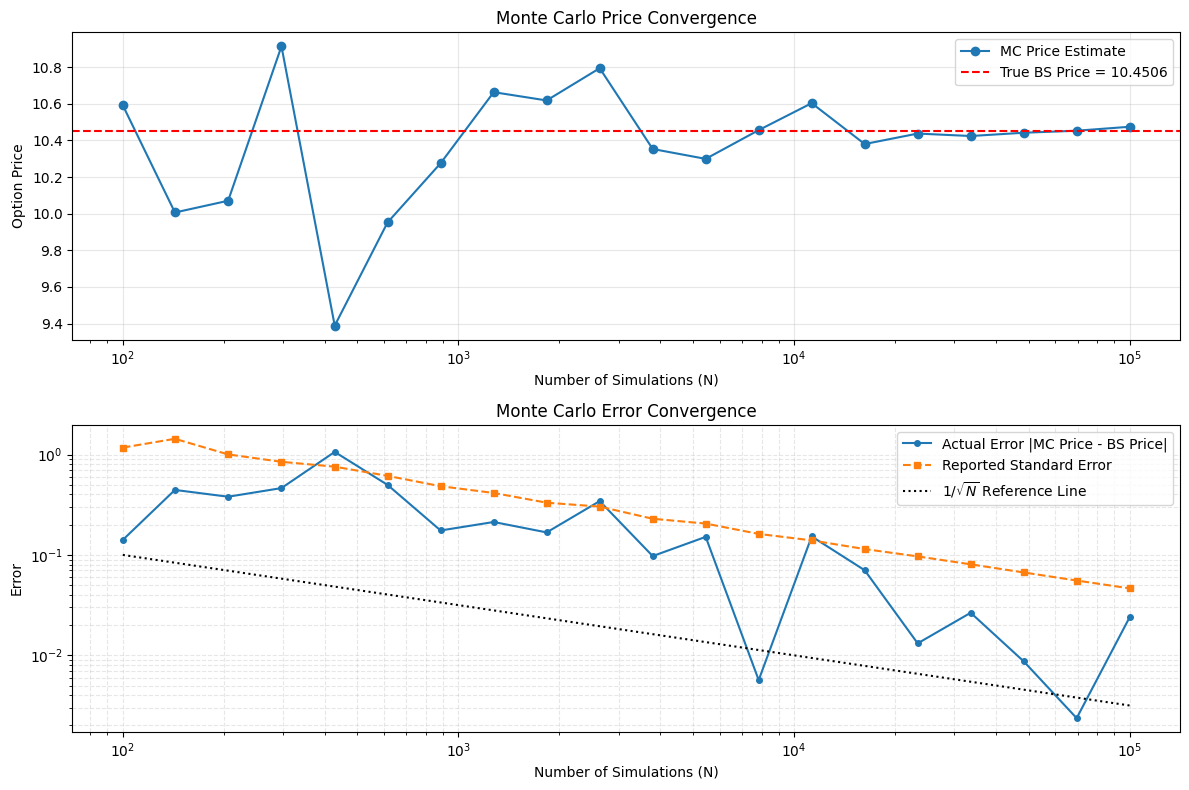

Final MC estimate with 100,000 simulations: 10.4745
Final error: 0.023946
Final standard error: 0.046452


In [3]:
np.random.seed(42)
n_sims_range = np.logspace(2, 5, 20, dtype=int) # From 100 to 100,000 simulations
errors = []
std_errors = []
prices = []

for n_sims in n_sims_range:
    result = mc_price_european(S, K, T, r, sigma, 'call', n_sims=n_sims, use_antithetic=False)
    price = result['price']
    prices.append(price)
    errors.append(abs(price - true_price))
    std_errors.append(result['std_error'])

# Create the convergence plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.semilogx(n_sims_range, prices, 'o-', label='MC Price Estimate')
plt.axhline(true_price, color='r', linestyle='--', label=f'True BS Price = {true_price:.4f}')
plt.title('Monte Carlo Price Convergence')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.loglog(n_sims_range, errors, 'o-', label='Actual Error |MC Price - BS Price|', markersize=4)
plt.loglog(n_sims_range, std_errors, 's--', label='Reported Standard Error', markersize=4)
plt.loglog(n_sims_range, 1 / np.sqrt(n_sims_range), 'k:', label='$1/\\sqrt{N}$ Reference Line')

plt.title('Monte Carlo Error Convergence')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Error')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key results
print(f"Final MC estimate with {n_sims_range[-1]:,} simulations: {prices[-1]:.4f}")
print(f"Final error: {errors[-1]:.6f}")
print(f"Final standard error: {std_errors[-1]:.6f}")

### 3. Variance Reduction Demonstration

Let's compare the standard error of the estimate with and without our variance reduction techniques (Antithetic Variates).

In [7]:
n_sims_fixed = 10000
n_runs = 100 # Run the simulation many times to see the distribution of errors

standard_prices = []
standard_errors = []
antithetic_prices = []
antithetic_errors = []

print("Running Monte Carlo simulations...")
for i in range(n_runs):
    if i % 20 == 0:
        print(f"Completed {i}/{n_runs} runs...")
    
    # Standard MC
    std_res = mc_price_european(S, K, T, r, sigma, 'call', n_sims=n_sims_fixed, use_antithetic=False)
    standard_prices.append(std_res['price'])
    standard_errors.append(std_res['std_error'])
    
    # MC with Antithetic Variates
    anti_res = mc_price_european(S, K, T, r, sigma, 'call', n_sims=n_sims_fixed, use_antithetic=True)
    antithetic_prices.append(anti_res['price'])
    antithetic_errors.append(anti_res['std_error'])

std_dev_standard = np.std(standard_prices)
std_dev_antithetic = np.std(antithetic_prices)
mean_std_error_standard = np.mean(standard_errors)
mean_std_error_antithetic = np.mean(antithetic_errors)

print(f"\n=== Variance Reduction Results ===\n")
print(f"True Black-Scholes Price: {true_price:.6f}")
print(f"\nStandard Monte Carlo:")
print(f"  Mean Price Estimate: {np.mean(standard_prices):.6f}")
print(f"  Standard Deviation: {std_dev_standard:.6f}")
print(f"  Average Reported Std Error: {mean_std_error_standard:.6f}")
print(f"  Bias: {np.mean(standard_prices) - true_price:.6f}")

print(f"\nAntithetic Variates Monte Carlo:")
print(f"  Mean Price Estimate: {np.mean(antithetic_prices):.6f}")
print(f"  Standard Deviation: {std_dev_antithetic:.6f}")
print(f"  Average Reported Std Error: {mean_std_error_antithetic:.6f}")
print(f"  Bias: {np.mean(antithetic_prices) - true_price:.6f}")

print(f"\n=== Improvement Metrics ===\n")
print(f"Variance Reduction Factor: {(std_dev_standard**2 / std_dev_antithetic**2):.2f}x")
print(f"Standard Error Reduction: {(std_dev_standard / std_dev_antithetic):.2f}x")
print(f"Efficiency Gain: {(mean_std_error_standard**2 / mean_std_error_antithetic**2):.2f}x")

Running Monte Carlo simulations...
Completed 0/100 runs...
Completed 20/100 runs...
Completed 40/100 runs...
Completed 60/100 runs...
Completed 80/100 runs...

=== Variance Reduction Results ===

True Black-Scholes Price: 10.450584

Standard Monte Carlo:
  Mean Price Estimate: 10.455239
  Standard Deviation: 0.077998
  Average Reported Std Error: 0.146888
  Bias: 0.004656

Antithetic Variates Monte Carlo:
  Mean Price Estimate: 10.429376
  Standard Deviation: 0.199903
  Average Reported Std Error: 0.073414
  Bias: -0.021207

=== Improvement Metrics ===

Variance Reduction Factor: 0.15x
Standard Error Reduction: 0.39x
Efficiency Gain: 4.00x


/tmp/ipykernel_98406/4199866586.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Standard MC', 'Antithetic MC'])


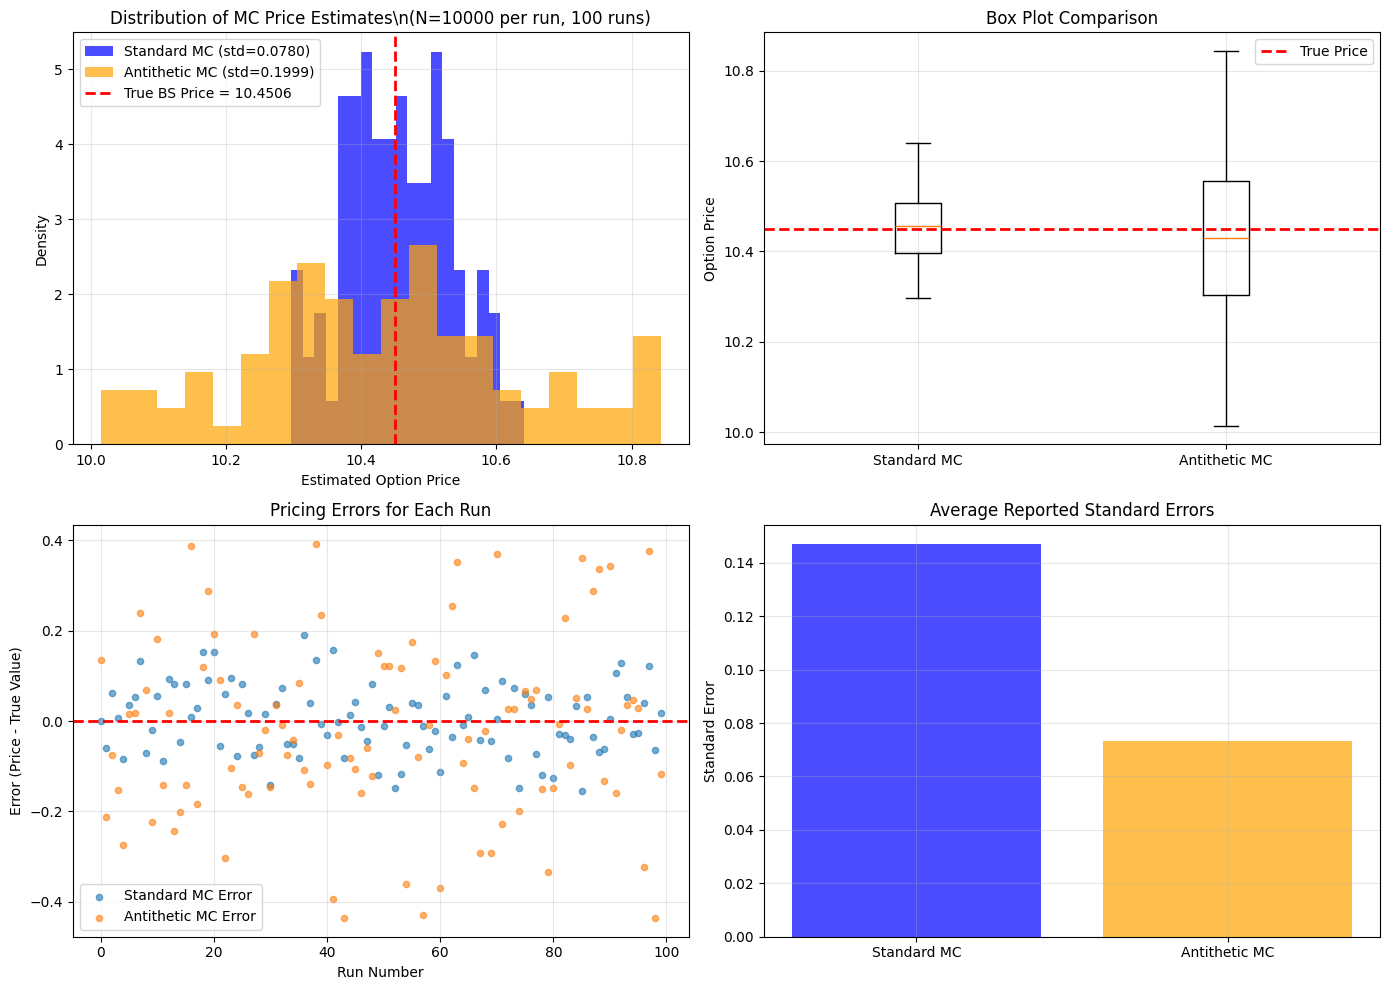

In [8]:
# Plotting the distributions
plt.figure(figsize=(14, 10))

# Distribution plot
plt.subplot(2, 2, 1)
plt.hist(standard_prices, bins=20, alpha=0.7, label=f'Standard MC (std={std_dev_standard:.4f})', density=True, color='blue')
plt.hist(antithetic_prices, bins=20, alpha=0.7, label=f'Antithetic MC (std={std_dev_antithetic:.4f})', density=True, color='orange')
plt.axvline(true_price, color='r', linestyle='--', linewidth=2, label=f'True BS Price = {true_price:.4f}')
plt.title(f'Distribution of MC Price Estimates\\n(N={n_sims_fixed} per run, {n_runs} runs)')
plt.xlabel('Estimated Option Price')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot comparison
plt.subplot(2, 2, 2)
box_data = [standard_prices, antithetic_prices]
plt.boxplot(box_data, labels=['Standard MC', 'Antithetic MC'])
plt.axhline(true_price, color='r', linestyle='--', linewidth=2, label=f'True Price')
plt.title('Box Plot Comparison')
plt.ylabel('Option Price')
plt.grid(True, alpha=0.3)
plt.legend()

# Error comparison
plt.subplot(2, 2, 3)
x_range = range(len(standard_prices))
plt.scatter(x_range, np.array(standard_prices) - true_price, alpha=0.6, label='Standard MC Error', s=20)
plt.scatter(x_range, np.array(antithetic_prices) - true_price, alpha=0.6, label='Antithetic MC Error', s=20)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.title('Pricing Errors for Each Run')
plt.xlabel('Run Number')
plt.ylabel('Error (Price - True Value)')
plt.legend()
plt.grid(True, alpha=0.3)

# Standard errors comparison
plt.subplot(2, 2, 4)
plt.bar(['Standard MC', 'Antithetic MC'], [mean_std_error_standard, mean_std_error_antithetic], 
        color=['blue', 'orange'], alpha=0.7)
plt.title('Average Reported Standard Errors')
plt.ylabel('Standard Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4. Additional Analysis: Convergence with Variance Reduction
Let's see how antithetic variates affect convergence across different numbers of simulations

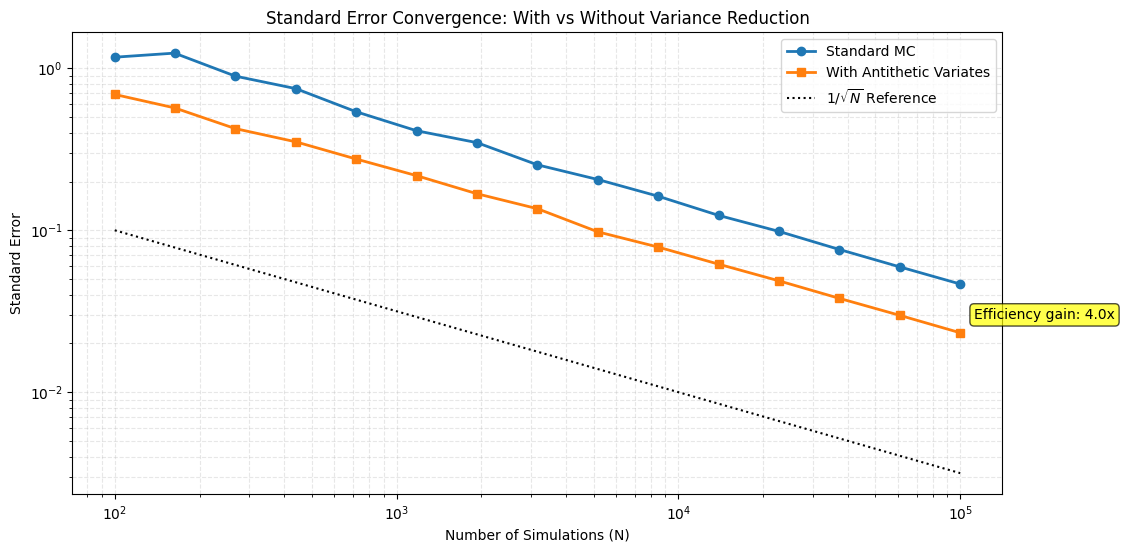

In [9]:
np.random.seed(42)
n_sims_convergence = np.logspace(2, 5, 15, dtype=int)

std_errors_without = []
std_errors_with = []

for n_sims in n_sims_convergence:
    # Without antithetic
    result_without = mc_price_european(S, K, T, r, sigma, 'call', n_sims=n_sims, use_antithetic=False)
    std_errors_without.append(result_without['std_error'])
    
    # With antithetic
    result_with = mc_price_european(S, K, T, r, sigma, 'call', n_sims=n_sims, use_antithetic=True)
    std_errors_with.append(result_with['std_error'])

plt.figure(figsize=(12, 6))
plt.loglog(n_sims_convergence, std_errors_without, 'o-', label='Standard MC', linewidth=2)
plt.loglog(n_sims_convergence, std_errors_with, 's-', label='With Antithetic Variates', linewidth=2)
plt.loglog(n_sims_convergence, 1 / np.sqrt(n_sims_convergence), 'k:', label='$1/\\sqrt{N}$ Reference')

plt.title('Standard Error Convergence: With vs Without Variance Reduction')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Standard Error')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add efficiency annotations
efficiency_ratio = (std_errors_without[-1] / std_errors_with[-1])**2
plt.annotate(f'Efficiency gain: {efficiency_ratio:.1f}x', 
             xy=(n_sims_convergence[-1], std_errors_with[-1]),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.show()